<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/HI_MAP_MATxSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c('raster','sf','data.table','magrittr','ggplot2','googledrive','exactextractr'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘sp’, ‘Rcpp’, ‘terra’, ‘classInt’, ‘s2’, ‘units’




In [2]:
library(data.table)
library(ggplot2)
library(magrittr)
library(googledrive)
library(sf)
library(raster)
library(exactextractr)

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE

Loading required package: sp



In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=d26e3f605fa59454a7c809377728784c&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWVhWVNIQjEyZWU1WkdRME1ldmhnSEhlNUxNT3ItRW0tNWZqVjl1RFRGeThPTmZBWkN2bWFTWDJGTXdCMGRRYThVZ3d1QSIsInN0YXRlIjoiZDI2ZTNmNjA1ZmE1OTQ1NGE3YzgwOTM3NzcyODc4NGMifQ==


HI soil health data

In [4]:
# https://drive.google.com/file/d/14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma/view?usp=drive_link
drive_download(file = as_id('14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma'), path = '/content/HSH.gpkg', overwrite = TRUE)

File downloaded:

• SH_dt_2024_02_21.gpkg <id: 14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma>

Saved locally as:

• /content/HSH.gpkg



HI climate mosaic

In [5]:
#https://drive.google.com/file/d/1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo/view?usp=drive_link
drive_download(as_id("1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo"), path = "/content/climate.tif", overwrite = TRUE)

# Read the downloaded TIFF file as a raster stack
climate_stack <- stack("/content/climate.tif")

# Check the content of the stack
print(climate_stack)

File downloaded:

• TerraClimate_Island_Mean_Climate_mosaic.tif
  <id: 1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo>

Saved locally as:

• /content/climate.tif



class      : RasterStack 
dimensions : 1075, 2638, 2835850, 14  (nrow, ncol, ncell, nlayers)
resolution : 0.008983153, 0.008983153  (x, y)
extent     : -178.4503, -154.7528, 18.86462, 28.52151  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : aet, def, pdsi, pet, pr, ro, soil, srad, swe, tmmn, tmmx, vap, vpd, vs 



In [6]:
# geopackage1 <- "/content/HSH.gpkg"

# Read the GeoPackages
soilHealth <- st_read("/content/HSH.gpkg")


st_crs(soilHealth) <- 4326



Reading layer `SH_dt' from data source `/content/HSH.gpkg' using driver `GPKG'
Simple feature collection with 767 features and 57 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -159.7518 ymin: 19.21385 xmax: -154.9476 ymax: 22.22142
Projected CRS: Undefined Cartesian SRS with unknown unit


Warning message:
“st_crs<- : replacing crs does not reproject data; use st_transform for that”


In [7]:
soilHealth <- soilHealth %>% st_transform(26904) %>% st_buffer(30)%>% st_transform(4326)

In [8]:
climate_extract<- exact_extract(climate_stack,soilHealth,fun = 'mean')
names(climate_extract) <- names(climate_stack)
soilHealth_dt <- data.table(soilHealth,climate_extract)

  |======================================================================| 100%


In [9]:
climate_stack


class      : RasterStack 
dimensions : 1075, 2638, 2835850, 14  (nrow, ncol, ncell, nlayers)
resolution : 0.008983153, 0.008983153  (x, y)
extent     : -178.4503, -154.7528, 18.86462, 28.52151  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : aet, def, pdsi, pet, pr, ro, soil, srad, swe, tmmn, tmmx, vap, vpd, vs 


In [10]:
climate_dt <- names(climate_stack) %>% lapply(function(x){dt_out = data.table(x=values(climate_stack[[x]]));names(dt_out)<- x;return(dt_out)}) %>% do.call(cbind,.)

climate_dt <- climate_dt[!is.na(pr)&pr>0]

In [11]:
min_max_dt <- rbindlist(lapply(names(climate_dt), function(col_name) {
  min_val <- min(climate_dt[[col_name]], na.rm = TRUE)
  max_val <- max(climate_dt[[col_name]], na.rm = TRUE)
  data.table(column = col_name, min = min_val, max = max_val)
}), use.names = TRUE)

In [12]:
norm_climate_dt <- names(climate_dt) %>%
  lapply(function(x){
  dt_out <- data.table(x=(climate_dt[[x]]-min_max_dt[column==x]$min[1])/(min_max_dt[column==x]$max[1]-min_max_dt[column==x]$min[1]) )
  names(dt_out) <- x
  return(dt_out)
  }) %>% do.call(cbind,.)

In [13]:
norm_soilHealth_dt <- names(climate_dt) %>%
  lapply(function(x){
  dt_out <- data.table(x=(soilHealth_dt[[x]]-min_max_dt[column==x]$min[1])/(min_max_dt[column==x]$max[1]-min_max_dt[column==x]$min[1]) )
  names(dt_out) <- x
  return(dt_out)
  }) %>% do.call(cbind,.)

In [14]:
# library(parallel)

# cl <-makeCluster(8)

# distance_dt <-
# 1:nrow(norm_climate_dt) %>% parLapply(cl,.,function(x,norm_climate_dt,norm_soilHealth_dt){
# # x <-1
# library(magrittr)
# library(data.table)
# dist_vec <- 1:nrow(norm_soilHealth_dt) %>% lapply(function(y){ mean(sqrt((norm_climate_dt[x,]-norm_soilHealth_dt[y,])^2) %>% unlist)}) %>% unlist
# data.table(id = which.min(dist_vec),min=min(dist_vec),mean=mean(dist_vec))
# # print(x)
# },norm_climate_dt,norm_soilHealth_dt) %>% rbindlist

# stopCluster(cl)

In [15]:
 seq(1, nrow(climate_dt), by = 1000)

[1]     1  1001  2001  3001  4001  5001  6001  7001  8001  9001 10001 11001
[13] 12001 13001 14001 15001 16001 17001 18001 19001 20001 21001

In [16]:
# matrix(norm_soilHealth_dt[1,])-matrix(norm_soilHealth_dt)

In [17]:
# # norm_climate_dt <- data.table(matrix(rnorm(10000), ncol = 10))
# # norm_soilHealth_dt <- data.table(matrix(rnorm(10000), ncol = 10))

# seq(1, nrow(climate_dt), by = 1000) %>% lapply(function(x){
# # # Calculate the Euclidean distance matrix
# dist_matrix <- as.matrix(dist(rbind(norm_climate_dt, norm_soilHealth_dt)))
# dist_matrix <- dist_matrix[1:nrow(norm_climate_dt), (nrow(norm_climate_dt) + 1):nrow(dist_matrix)]
# # Find the minimum, mean, and index of the minimum for each row
# min_indices <- apply(dist_matrix, 1, which.min)
# min_values <- apply(dist_matrix, 1, min)
# mean_values <- apply(dist_matrix, 1, mean)

# # # Create the resulting data.table
# distance_dt <- data.table(id = min_indices, min = min_values, mean = mean_values)

#   })

# # Calculate distances using the batch processing function
# distance_dt <- calc_distances(norm_climate_dt, norm_soilHealth_dt, batch_size = 100)


In [18]:
# distance_dt$min %>% qplot

In [19]:
names(norm_climate_dt)
norm_climate_dt <- norm_climate_dt[,.(pr,tmmx)]
norm_soilHealth_dt <- norm_soilHealth_dt[,.(pr,tmmx)]

[1] "aet"  "def"  "pdsi" "pet"  "pr"   "ro"   "soil" "srad" "swe"  "tmmn"
[11] "tmmx" "vap"  "vpd"  "vs"

In [20]:
# # Assuming norm_climate_dt and norm_soilHealth_dt are your data.tables
# # with rows as observations and columns as dimensions

# # Calculate the Euclidean distance matrix
# dist_matrix <- as.matrix(dist(rbind(norm_climate_dt, norm_soilHealth_dt)))
# dist_matrix <- dist_matrix[1:nrow(norm_climate_dt), (nrow(norm_climate_dt) + 1):nrow(dist_matrix)]

# # Find the minimum, mean, and index of the minimum for each row
# min_indices <- apply(dist_matrix, 1, which.min)
# min_values <- apply(dist_matrix, 1, min)
# mean_values <- apply(dist_matrix, 1, mean)

# # Create the resulting data.table
# distance_dt <- data.table(id = min_indices, min = min_values, mean = mean_values)

In [21]:
norm_soilHealth_dt

pr,tmmx
<dbl>,<dbl>
0.19758687,0.9186816
0.19758687,0.9186816
0.19758687,0.9186816
0.19758685,0.9186816
0.19758685,0.9186816
0.19758685,0.9186816
0.43567235,0.9382836
0.43567235,0.9382836
0.43782766,0.9387582


In [22]:
# climate_dt %>% names %>% lapply(


# )

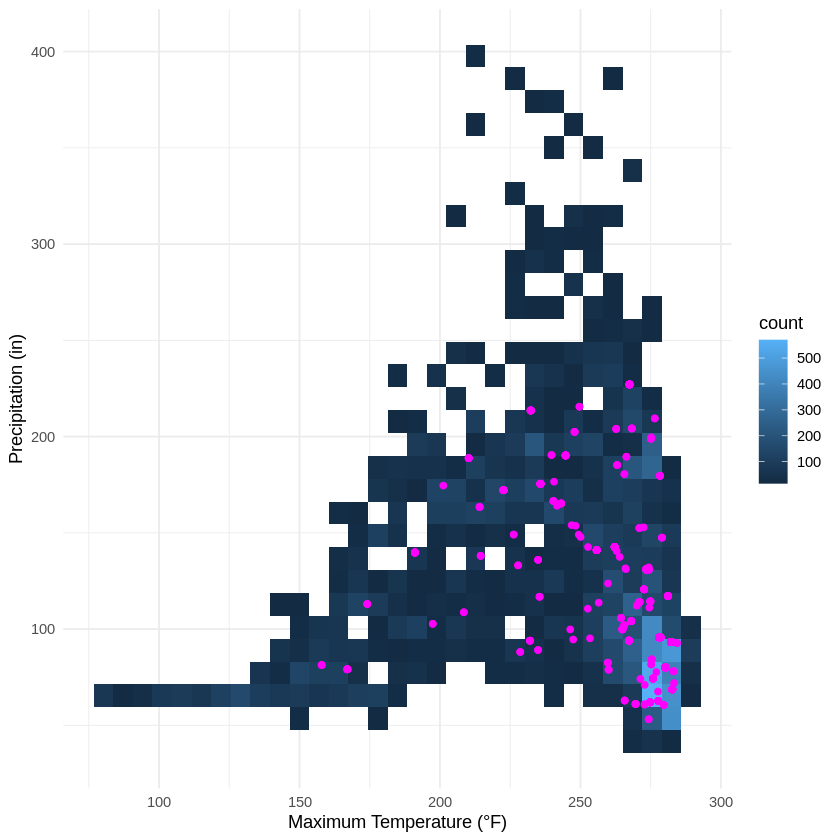

In [27]:
climate_dt %>%
  ggplot(aes(x=tmmx,y=pr))+
  geom_bin2d() +
  geom_point(data=soilHealth_dt,aes(x=tmmx,y=pr),color='magenta')+
  labs(x = "Maximum Temperature (°F)", y = "Precipitation (in)") +
  theme_minimal()